# Question

Is there an easy way to merge circuits, so take 3 pregenerated circuits and merge them to one big one?

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

# 1. Try for steane typ QEC code

Using a surface 17 code of distance 3.

## Basic plan. 

1. initalize 3 logical qubits, $\ket{\Psi}_L$, $\ket{0}_L$, $\ket{+}_L$
    + We use surface 17 circuits with distance 3
2. test implementation of surface 17 code! (works !!)
    + compared to previous solutions and returned same results
3. add measurement of the auxillary qubits!
4. add encoding  (Fix)
5. work out the error ?! 

## Questions

In [66]:
# Stabilizers for the 3 distance surface17 code
Z_stabilizers = [
    [1,0,0,1,0,0,0,0,0],
    [0,0,0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0,0,0],
    [0,0,0,0,0,1,0,0,1]
    ]
X_stabilizers = [
    [0,1,1,0,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,1,1],
    [0,0,0,0,0,0,1,1,0]
    ]

def generate_qubit_indices(
        index_unused_qubit:int, 
        gen_x_stabilizer:bool=True, 
        gen_z_stabilizer:bool=True,
        ):
    """
    We are starting from the last used qubit and generate the indices of:
    9 data qubits 
    4 Z measure qubits
    4 X measure qubits
    and returns those as a dict
    """
    data_qubits = np.arange(index_unused_qubit,index_unused_qubit + 9)
    index_unused_qubit += 9
    log_qubit_indices = {
        "data": data_qubits,
        }
    if gen_z_stabilizer:
        Z_measure_qubits = np.arange(index_unused_qubit,index_unused_qubit + 4)
        index_unused_qubit += 4
        log_qubit_indices.update({ 
            "Z_measure": Z_measure_qubits,
        })
    if gen_x_stabilizer:
        X_measure_qubits = np.arange(index_unused_qubit,index_unused_qubit + 4)
        index_unused_qubit += 4
        log_qubit_indices.update({ 
            "X_measure": X_measure_qubits,
        })
    return index_unused_qubit, log_qubit_indices 

def add_stabilizer(
        circuit, 
        index_unused_qubit, 
        total_measurements, 
        gen_x_stabilizer=True, 
        gen_z_stabilizer=True, 
        log_qubit_indices=None,
        ):
    """
    Adds a surface 17 stabilizer qubit to the circuit, with the given qubits
    with the option to turn off the not needed stabilizer qubits
    """
    if not log_qubit_indices:
        index_unused_qubit, log_qubit_indices = generate_qubit_indices(index_unused_qubit,gen_x_stabilizer,gen_z_stabilizer)
    data_qubits = log_qubit_indices["data"]

    if gen_z_stabilizer:
        Z_measure_qubits = log_qubit_indices["Z_measure"]
        # Z stabilizers: C(data)NOT(measure)
        for i,stabilizer in enumerate(Z_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                # CxNOTy (of the list) "CNOT",[x,y]
                circuit.append("CNOT",[data_qubits[j],Z_measure_qubits[i]])
        circuit.append("MR", Z_measure_qubits)
        total_measurements += len(Z_measure_qubits)

        # for i in range(4):
            # circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
        circuit.append("TICK")

    if gen_x_stabilizer:
        X_measure_qubits = log_qubit_indices["X_measure"]
        # X stabilizers: H(measure) C(measure)NOT(data) H(measure)
        circuit.append("H",X_measure_qubits)
        circuit.append("TICK")
        for i,stabilizer in enumerate(X_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                circuit.append("CNOT",[X_measure_qubits[i],data_qubits[j]])
        circuit.append("TICK")
        circuit.append("H",X_measure_qubits)
        circuit.append("TICK")
        circuit.append("MR", X_measure_qubits)
        total_measurements += len(X_measure_qubits)
        # for i in range(4):
            # circuit.append("DETECTOR",[stim.target_rec(-(i+1))])
        circuit.append("TICK")
    return circuit, index_unused_qubit, total_measurements, log_qubit_indices


In [ ]:
def gen_steane_circuit(noise,
                       surface_code=False,
                       aux_p_qubit_used=True,
                       aux_0_qubit_used=True,
                       X_errors=False,
                       Z_errors=False,
                       ):
    # We have to track the total measurements to be able to refer to the measurements by the absolute value when defining detectors.
    total_measurements = 0
    # We could also use relative measurements indicies but that would be to easy 
    if surface_code:
        aux_0_qubit_used = False
        aux_p_qubit_used = False
    # surface_code = True if I just want to simulate a surface 17 code
    steane_circuit = stim.Circuit()
    # generate indices & initialize qubits
    index_unused_qubit = 0  # tracked to offset the following aux qubits
    steane_circuit, index_unused_qubit, total_measurements, general_qubit = add_stabilizer(steane_circuit, index_unused_qubit, total_measurements, gen_z_stabilizer=False)

    # set up errors 
    if aux_0_qubit_used or Z_errors:
        steane_circuit.append("Z_ERROR",general_qubit["data"],noise)
    if aux_p_qubit_used or X_errors:
        steane_circuit.append("X_ERROR",general_qubit["data"],noise)
    steane_circuit.append("TICK")

    # The second set of stabilizers is just needed for the surface 17 code
    if surface_code:
        steane_circuit, total_measurements = add_stabilizer(steane_circuit, general_qubit, total_measurements)
        i_first_x_stab_measure = 4
        n_stab_measures = 4
        for i in range(n_stab_measures):
            rel_index_old_measurement = (i_first_x_stab_measure + i) - total_measurements 
            rel_index_new_measurement = i - n_stab_measures 
            steane_circuit.append("DETECTOR",[stim.target_rec(rel_index_old_measurement),stim.target_rec(rel_index_new_measurement)])
    
    if aux_0_qubit_used:
        measurements_before_aux_0 = total_measurements
        # initalize aux qubit
        steane_circuit, index_unused_qubit, total_measurements, aux_0_qubit = add_stabilizer(steane_circuit, index_unused_qubit, total_measurements, gen_z_stabilizer=False)
        steane_circuit.append("TICK")
        # entangle aux qubit 
        for i, _ in enumerate(general_qubit["data"]):
                steane_circuit.append("CNOT",[aux_0_qubit["data"][i],general_qubit["data"][i]])
        steane_circuit.append("TICK")
        # measure aux qubit 
        steane_circuit.append("H",aux_0_qubit["data"])
        steane_circuit.append("MR",aux_0_qubit["data"])
        total_measurements += len(aux_0_qubit["data"])
        steane_circuit.append("TICK")
        # Set up Detectors 
        # They have to be deterministic! (XORing each input) 
        # encoding parity =(needs to be) measured parity [eg: rec(0) + rec(4) = rec(9) + rec(10)] => detector(0,4,9,10)
        x = measurements_before_aux_0
        detection_sets = [
            [0,0+x,5+x,6+x], 
            [1,1+x,4+x,5+x,7+x,8+x], 
            [2,2+x,8+x,9+x,11+x,12+x],
            [3,3+x,10+x,11+x],
        ]
        del x # cleanup the temp variable
        for i, set in enumerate(detection_sets):
            rel_index = [x - total_measurements for x in set]
            steane_circuit.append("DETECTOR",
            [stim.target_rec(x) for x in rel_index]
                                  ) 
        steane_circuit.append("TICK")

    if aux_p_qubit_used:
        measurements_before_aux_0 = total_measurements
        # initialize aux qubit
        index_unused_qubit, aux_p_qubit = generate_qubit_indices(index_unused_qubit,gen_x_stabilizer=False)
        steane_circuit.append("H",aux_p_qubit["data"]) # initalize in |+>-state
        steane_circuit, _, total_measurements, _ = add_stabilizer(
            steane_circuit, 
            index_unused_qubit, 
            total_measurements, 
            gen_x_stabilizer=False, 
            log_qubit_indices=aux_p_qubit
            )
        steane_circuit.append("TICK")
        # entangle aux qubit
        for i, _ in enumerate(general_qubit["data"]):
            steane_circuit.append("CNOT",[general_qubit["data"][i],aux_p_qubit["data"][i]])
        steane_circuit.append("TICK")
        # measure aux qubit
        steane_circuit.append("MR",aux_p_qubit["data"])
        total_measurements += len(aux_p_qubit["data"])
        # Set up Detectors
        x = measurements_before_aux_0
        detection_sets = [
            [0+x,4+x,7+x], 
            [1+x,7+x,8+x,10+x,11+x], 
            [2+x,5+x,6+x,8+x,9+x],
            [3+x,9+x,12+x],
        ]
        del x 
        for i, set in enumerate(detection_sets):
            rel_index = [x - total_measurements for x in set]
            steane_circuit.append("DETECTOR",
            [stim.target_rec(x) for x in rel_index]
                                  ) 
        steane_circuit.append("TICK")

    # measure general qubit
    steane_circuit.append("M",general_qubit["data"])
    total_measurements += len(general_qubit["data"])
    steane_circuit.append("OBSERVABLE_INCLUDE",[stim.target_rec(-(i+1)) for i in range(9)],0)
    steane_circuit.append("TICK")
    return steane_circuit

steane_circuit = gen_steane_circuit(0,
                                    aux_0_qubit_used=True,
                                    aux_p_qubit_used=True,
                                    )
steane_circuit.diagram("timeline-svg")

if 1:
    diagram = steane_circuit.diagram("timeline-svg")  
    with open('my_circuit.svg', 'w') as f:
        f.write(str(diagram))


In [68]:
# The CNOTS gates entangle with the original qubits => they need to be taken into account !
# do the mathhhhh!

sampler = steane_circuit.compile_detector_sampler()
print(sampler.sample(shots=1))

sampler = steane_circuit.compile_sampler()
one_shot = sampler.sample(shots=1)[0]
detection_sets = [
            [4,9,10], 
            [5,8,9,11,12], 
            [6,12,13,15,16],
            [7,14,15],
        ]

print(one_shot)
print([np.sum(one_shot[i])%2 for i in detection_sets])

[[False False False False False False False False]]
[ True  True False  True False False False  True  True  True False False
  True False  True  True False  True False  True  True False False  True
  True False False False  True  True False False False False False False
  True  True False]
[np.int64(1), np.int64(1), np.int64(0), np.int64(1)]


In [69]:
dem = steane_circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
    detector D5
    detector D6
    detector D7
    logical_observable L0
''')


In [70]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [71]:
num_shots = 100_000
num_logical_errors = count_logical_errors(steane_circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 0 wrong predictions (logical errors) out of 100000 shots


/tmp/ipykernel_6115/2100694996.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


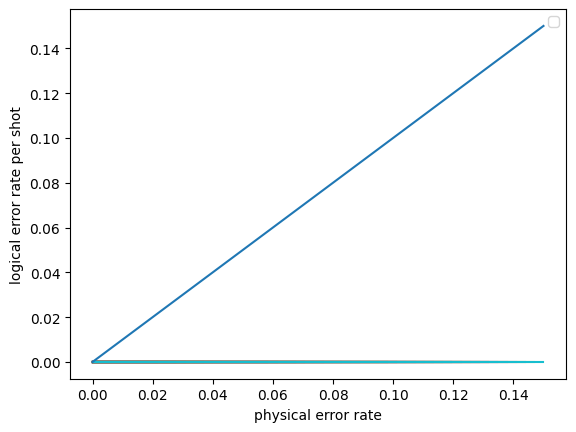

In [ ]:

num_shots = 10_000
#for circuit in [gen_steane_circuit(1)]:
if 1:
    xs = []
    ys = []
    for noise in np.linspace(0,0.15):
        circuit = gen_steane_circuit(
            noise,
            aux_0_qubit_used=True,
            aux_p_qubit_used=False, 
            )
        diagram = circuit.diagram('timeline-svg')
        with open('problem.svg', 'w') as f:
            f.write(str(diagram))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
        plt.plot(xs,ys)
#plt.loglog()
#plt.plot(np.linspace(0,0.15),np.linspace(0,0.15))
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()